<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/yoy_var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# font size

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# stability and variability

based loosely on this  
https://tonyelhabr.rbind.io/posts/soccer-meta-analytics/  


In [ ]:
!pip install pybaseball
!pip install adjustText

<IPython.core.display.Javascript object>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 7.1 MB/s eta 0:00:00


In [ ]:
import pybaseball as bb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, percentileofscore
from adjustText import adjust_text

<IPython.core.display.Javascript object>

In [ ]:
_df = bb.fg_pitching_data(start_season=1993, end_season=2023)
cols = [
    'W','WAR', 'ERA','SV','IP',  'H', 'R', 'ER',
    'HR', 'BB','SO', 'GB', 'FB', 'LD','BU', 'K/9',
    'BB/9', 'K/BB', 'H/9', 'HR/9', 'AVG', 'WHIP', 'BABIP',
    'LOB%', 'FIP', 'GB/FB', 'LD%', 'GB%', 'FB%','HR/FB','RAR',
    'tERA', 'xFIP', 'WPA', '-WPA', '+WPA','pLI', 'inLI', 'gmLI', 'exLI',
    'WPA/LI', 'Clutch','O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%',
    'Z-Contact%', 'Contact%', 'Zone%', 'F-Strike%', 'SwStr%','ERA-',
    'FIP-', 'xFIP-','K%', 'BB%', 'SIERA', 'RS/9', 'K/9+', 'BB/9+',
    'K/BB+', 'H/9+', 'HR/9+', 'AVG+', 'WHIP+',
    'BABIP+', 'LOB%+', 'K%+', 'BB%+', 'LD%+', 'GB%+', 'FB%+',
    'HR/FB%+','Pull%+', 'Cent%+', 'Oppo%+', 'Soft%+', 'Med%+',
    'Hard%+', 'EV', 'LA', 'Barrels', 'Barrel%', 'maxEV', 'HardHit',
    'HardHit%','Stuff+', 'Location+', 'Pitching+',
]

<IPython.core.display.Javascript object>

In [ ]:
_df1 = _df.loc[:, ['Season', 'ERA']].groupby('Season', as_index=False).std()

<IPython.core.display.Javascript object>

,Season,ERA
0,1993,0.766964
1,1994,1.035824
2,1995,0.766646
3,1996,0.842391
4,1997,0.868261
5,1998,0.877856
6,1999,0.822362
7,2000,0.817902
8,2001,0.750461
9,2002,0.800229


<IPython.core.display.Javascript object>

58

In [ ]:
s

<IPython.core.display.Javascript object>

1

<IPython.core.display.Javascript object>

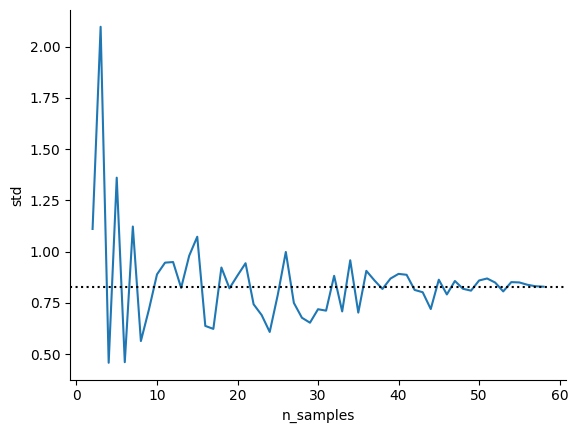

In [ ]:
col = 'ERA'
season = 2018
_df_plt = _df.loc[_df['Season']==season]
std = _df_plt[col].std()
values = pd.DataFrame()
for s in range(1,_df_plt.shape[0]+1):
  _values = pd.DataFrame()
  value = _df_plt['ERA'].sample(s).std()
  _values['n_samples'] = [s]
  _values['std'] = value
  values = pd.concat([values,_values])
values = values.reset_index(drop=True)

sns.lineplot(data=values, x='n_samples', y='std')
sns.despine()
plt.axhline(std, c='k', ls=':')
plt.show()

<IPython.core.display.Javascript object>

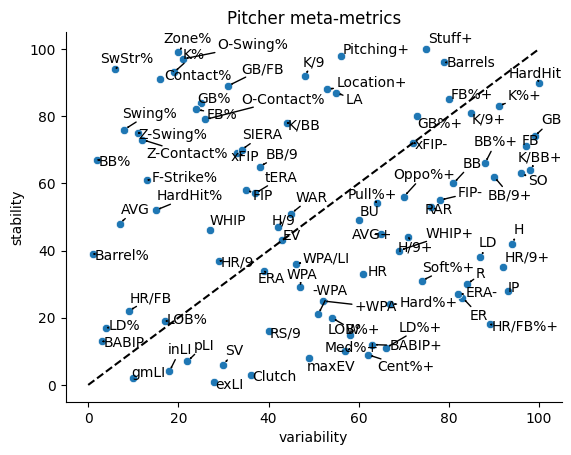

In [ ]:
itsmetoeknee = pd.DataFrame()

for col in cols:
  _itsmetoeknee = pd.DataFrame()
  std = _df[col].dropna().std()

  _df1 = _df.loc[:, ['IDfg', 'Season', f'{col}']].dropna().copy()
  _df2 = _df1.copy()
  _df2['Season'] = _df2['Season'].sub(1)
  _df1 = _df1.merge(_df2, on=['IDfg','Season'], suffixes=('', '_next'))
  r2 = spearmanr(_df1[f'{col}'], _df1[f'{col}_next'])[0]**2

  _itsmetoeknee['metric'] = [col]
  _itsmetoeknee['stability'] = r2
  _itsmetoeknee['variability'] = std
  itsmetoeknee = pd.concat([itsmetoeknee, _itsmetoeknee])

itsmetoeknee = itsmetoeknee.reset_index(drop=True)
for col in ['stability', 'variability']:
  itsmetoeknee[col] = pd.Series(percentileofscore(itsmetoeknee[col], itsmetoeknee[col])).round().astype(int)

sns.scatterplot(data=itsmetoeknee, y='stability', x='variability')
plt.plot([0,100],[0,100],'k--')
texts = [plt.text(row['variability'], row['stability'], row['metric']) for idx, row in itsmetoeknee.iterrows()]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=1))
plt.title('Pitcher meta-metrics')
sns.despine()
plt.show()


In [ ]:
itsmetoeknee.head()

<IPython.core.display.Javascript object>

,metric,stability,variability
0,W,20,54
1,WAR,51,45
2,ERA,34,39
3,SV,6,30
4,IP,28,93


In [ ]:
_df = bb.fg_batting_data(start_season=1993, end_season=2023)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

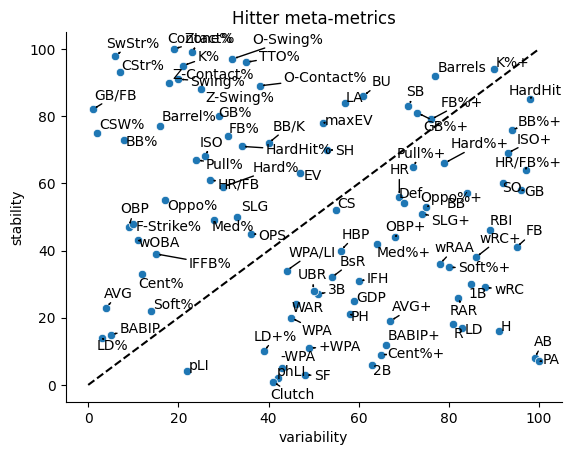

In [ ]:
cols = [
    'AB', 'PA', 'H','1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB',
    'SO', 'HBP', 'SF','SH', 'GDP', 'SB', 'CS', 'AVG', 'GB', 'FB', 'LD',
    'IFH', 'BU','BB%', 'K%','BB/K', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP',
    'GB/FB', 'LD%', 'GB%','FB%', 'IFFB%', 'HR/FB','wOBA', 'wRAA', 'wRC',
    'RAR', 'WAR','wRC+',
    'WPA', '-WPA', '+WPA', 'pLI', 'phLI','PH',
    'WPA/LI', 'Clutch','O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%',
    'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'BsR','Def','UBR','Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%',
    'TTO%','AVG+', 'BB%+', 'K%+', 'OBP+', 'SLG+', 'ISO+', 'BABIP+',
    'LD+%', 'GB%+', 'FB%+', 'HR/FB%+', 'Pull%+', 'Cent%+', 'Oppo%+',
    'Soft%+', 'Med%+', 'Hard%+', 'EV', 'LA', 'Barrels', 'Barrel%',
    'maxEV', 'HardHit', 'HardHit%', 'CStr%', 'CSW%'
]

tony = pd.DataFrame()
for col in cols:
  _tony = pd.DataFrame()
  std = _df[col].dropna().std()

  _df1 = _df.loc[:, ['IDfg','Season',col]].dropna().copy()
  _df2 = _df1.copy()
  _df2['Season'] = _df2['Season'].sub(1)
  _df1 = _df1.merge(_df2, on=['IDfg','Season'], suffixes=('', '_next'))
  r2 = spearmanr(_df1[col], _df1[f"{col}_next"])[0]**2
  _tony['metric'] = [col]
  _tony['stability'] = r2
  _tony['variability'] = std
  tony = pd.concat([tony,_tony])
tony = tony.reset_index(drop=True)

for col in ['stability','variability']:
  tony[col] = pd.Series(percentileofscore(tony[col], tony[col]), index=tony.index).round().astype(int)

sns.scatterplot(data=tony, y='stability', x='variability')
plt.plot([0,100],[0,100],'k--')
texts = [plt.text(row['variability'], row['stability'], row['metric']) for idx, row in tony.iterrows()]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=1))
plt.title('Hitter meta-metrics')
sns.despine()
plt.show()

In [ ]:
_df.columns.values

<IPython.core.display.Javascript object>

array(['IDfg', 'Season', 'Name', 'Team', 'Age', 'G', 'AB', 'PA', 'H',
       '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF',
       'SH', 'GDP', 'SB', 'CS', 'AVG', 'GB', 'FB', 'LD', 'IFFB',
       'Pitches', 'Balls', 'Strikes', 'IFH', 'BU', 'BUH', 'BB%', 'K%',
       'BB/K', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'GB/FB', 'LD%', 'GB%',
       'FB%', 'IFFB%', 'HR/FB', 'IFH%', 'BUH%', 'wOBA', 'wRAA', 'wRC',
       'Bat', 'Fld', 'Rep', 'Pos', 'RAR', 'WAR', 'Dol', 'Spd', 'wRC+',
       'WPA', '-WPA', '+WPA', 'RE24', 'REW', 'pLI', 'phLI', 'PH',
       'WPA/LI', 'Clutch', 'FB% (Pitch)', 'FBv', 'SL%', 'SLv', 'CT%',
       'CTv', 'CB%', 'CBv', 'CH%', 'CHv', 'SF%', 'SFv', 'KN%', 'KNv',
       'XX%', 'PO%', 'wFB', 'wSL', 'wCT', 'wCB', 'wCH', 'wSF', 'wKN',
       'wFB/C', 'wSL/C', 'wCT/C', 'wCB/C', 'wCH/C', 'wSF/C', 'wKN/C',
       'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%',
       'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'BsR', 'FA% (sc)',
       'FT% (sc)'

In [ ]:
_df1 = _df.copy()
_df1['Dol'] = _df1['Dol'].str.replace('$','').str.replace('(','').str.replace(')','').astype(float)
_df1 = _df1.loc[:, ['Season', 'Team', 'Dol', 'WAR']].groupby(['Season', 'Team'], as_index=False).mean()
_df1['$/WAR'] = _df1['Dol'].div(_df1['WAR'])
_df1.loc[_df1['Season']==2013]

<IPython.core.display.Javascript object>

,Season,Team,Dol,WAR,$/WAR
610,2013,- - -,11.737500,1.587500,7.393701
611,2013,ARI,26.000000,3.500000,7.428571
612,2013,ATL,23.180000,3.120000,7.429487
613,2013,BAL,25.985714,3.485714,7.454918
614,2013,BOS,29.066667,3.933333,7.389831
615,2013,CHC,6.800000,0.750000,9.066667
616,2013,CHW,12.850000,0.975000,13.179487
617,2013,CIN,28.750000,3.883333,7.403433
618,2013,CLE,18.100000,2.450000,7.387755
619,2013,COL,23.533333,3.166667,7.431579
